# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

# Area of Mandlebrot Set using Monte Carlo Method

# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [35]:
import math
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from Mandelbrot import inMandelbrotSet


def RS_circle(iter_num, s_num, R=2):
    '''Compute the area of the Mandelbrot set by pure random sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A: the area of the Mandelbrot set
    '''
    N = 0  # Number of points that are in the Mandelbrot set
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        theta = U1 * 2 * math.pi
        r = R * math.sqrt(U2)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        N += inMandelbrotSet(c, iter_num)

    # Compute the area of the Mandelbrot set
    A_total = math.pi * R**2  # The area of the sampling region
    A = N / s_num * A_total

    return A


def LHS_circle(iter_num, s_num, R=2):
    '''Compute the area of the Mandelbrot set by Latin Hypercube Sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A: the area of the Mandelbrot set
    '''
    N = 0  # Number of points that are in the Mandelbrot set
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        # Split the circular sampling region into s sectors, and get the RV: theta
        theta = 2 * math.pi * (s + U1) / s_num
        # Divide the sector into s equal parts of equal area, and get the RV: r
        r = R * math.sqrt((idx[s] + U2) / s_sum)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        N += inMandelbrotSet(c, iter_num)

    # Compute the area of the Mandelbrot set
    A_total = math.pi * R**2  # The area of the sampling region
    A = N / s_num * A_total

    return A


# def IS_circle()

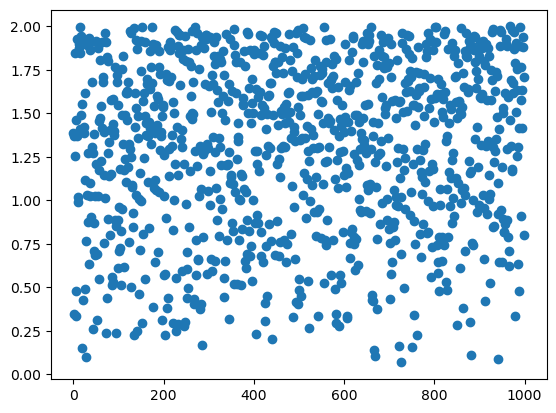

In [37]:
def test():
    s_num = 5
    R = 2
    s = 0
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    U2 = np.random.uniform(0, 1)
    r = R * math.sqrt((idx[s] + U2) / s_num)
    return r

xs = np.arange(1000)
rs = []
for x in xs:
    rs.append(test())

plt.figure()
plt.scatter(xs, rs)
plt.show()